Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

## Background
This is part of a release of experimental data determined at AstraZeneca on a set of compounds in the following assays: pKa, lipophilicity (LogD7.4), aqueous solubility, plasma protein binding (human, rat, dog , mouse and guinea pig), intrinsic clearance (human liver microsomes, human and rat hepatocytes). 

## Description of readout:
- **SOLUBILITY_74**: Solubility in pH7.4 buffer using solid starting material using the method described in J. Assoc. Lab. Autom. 2011, 16, 276-284.

## Data resource

**Reference**: https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/

**Raw data**: https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL3301364/

In [1]:
import datamol as dm

from polaris import (
    curation,
    load_dataset,
)
from polaris.curation.viz_utils import (
    visualize_distribution,
    verify_stereoisomers,
    check_undefined_stereocenters,
)
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.utils.types import HubOwner, License
from polaris.hub.client import PolarisHubClient

import tempfile

# For downloading ChEMBL datasets
from chembl_webresource_client.new_client import new_client as client
from tqdm.auto import tqdm
import warnings
import pandas as pd

We can get the dataset directly from ChEMBL (https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/ gives the overall experimental data information, and subsequent numbers give data for a specific endpoint). The following map gives information on each:

In [2]:
# chembl_map = {
#     'CHEMBL3301362' : 'Most basic pKa value (pKa B1)', # 261
#     'CHEMBL3301363' : 'Octan-1-ol/water (pH7.4) distribution coefficent', # 4200
#     'CHEMBL3301364' : 'Solubility in pH7.4 buffer', #1763
#     'CHEMBL3301365' : '\% bound to plasma by equilibrium dialysis, human plasma', # PPB # 1614
#     'CHEMBL3301366' : '\% bound to plasma by equilibrium dialysis, rat plasma', # 717
#     'CHEMBL3301367' : '\% bound to plasma by equilibrium dialysis, dog plasma', # 244
#     'CHEMBL3301368' : '\% bound to plasma by equilibrium dialysis, mouse plasma', # 162
#     'CHEMBL3301369' : '\% bound to plasma by equilibrium dialysis, guinea pig plasma', # 91
#     'CHEMBL3301370' : 'Intrinsic clearance measured in human liver microsomes', #1102,
#     'CHEMBL3301371' : 'Intrinsic clearance measured in rat hepatocytes', # 837
#     'CHEMBL3301372' : 'Intrinsic clearance measured in human hepatocytes', # 408
# }

In [3]:
# load data
data = pd.read_parquet('gs://polaris-public/data/raw/AstraZeneca/CHEMBL3301364_raw.parquet')
data

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,14759455,[],CHEMBL3301364,ASTRAZENECA: Solubility in pH7.4 buffer using ...,P,None,None,BAO_0002135,...,None,No relevant target,None,None,None,Solubility,uM,UO_0000065,None,81.3
1,None,None,14759456,[],CHEMBL3301364,ASTRAZENECA: Solubility in pH7.4 buffer using ...,P,None,None,BAO_0002135,...,None,No relevant target,None,None,None,Solubility,uM,UO_0000065,None,81.3
2,None,None,14759457,[],CHEMBL3301364,ASTRAZENECA: Solubility in pH7.4 buffer using ...,P,None,None,BAO_0002135,...,None,No relevant target,None,None,None,Solubility,uM,UO_0000065,None,83.2
3,None,None,14759458,[],CHEMBL3301364,ASTRAZENECA: Solubility in pH7.4 buffer using ...,P,None,None,BAO_0002135,...,None,No relevant target,None,None,None,Solubility,uM,UO_0000065,None,83.2
4,None,None,14759459,[],CHEMBL3301364,ASTRAZENECA: Solubility in pH7.4 buffer using ...,P,None,None,BAO_0002135,...,None,No relevant target,None,None,None,Solubility,uM,UO_0000065,None,83.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,None,None,14770631,[],CHEMBL3301364,ASTRAZENECA: Solubility in pH7.4 buffer using ...,P,None,None,BAO_0002135,...,None,No relevant target,None,None,None,Solubility,uM,UO_0000065,None,81.3
1759,None,None,14770632,[],CHEMBL3301364,ASTRAZENECA: Solubility in pH7.4 buffer using ...,P,None,None,BAO_0002135,...,None,No relevant target,None,None,None,Solubility,uM,UO_0000065,None,81.3
1760,None,None,14770633,[],CHEMBL3301364,ASTRAZENECA: Solubility in pH7.4 buffer using ...,P,None,None,BAO_0002135,...,None,No relevant target,None,None,None,Solubility,uM,UO_0000065,None,81.3
1761,None,None,14770634,[],CHEMBL3301364,ASTRAZENECA: Solubility in pH7.4 buffer using ...,P,None,None,BAO_0002135,...,None,No relevant target,None,None,None,Solubility,uM,UO_0000065,None,81.3


If we look at the columns in this raw dataframe, we see there are a lot of columns that we don't need. We will focus only on necessary columns below.

In [4]:
print(data.columns)

columns_to_keep = [
    "canonical_smiles",
    "standard_value",
]
data = data[columns_to_keep].copy()

# Convert the readout to numeric values
data["standard_value"] = pd.to_numeric(data["standard_value"])

# Rename columns
data = data.rename(
    columns={
        "canonical_smiles": "SMILES",
        "standard_value": "SOLUBILITY_74",
    }
)

data

Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')


,SMILES,SOLUBILITY_74
0,O=C(O)c1cc2cc(Cl)ccc2n1Cc1ccc(Cl)c(Cl)c1,81300.0
1,COc1cc(OC2CNC2)ccc1Nc1ncc(Cl)c(-c2cnc3ccccn23)n1,81300.0
2,CCOC(=O)Nc1ccc2c(c1)N(C(=O)CCN1CCOCC1)c1ccccc1S2,83200.0
3,Nc1nc(-c2ccc(Cl)cc2)cs1,83200.0
4,CC(C)c1ccc2[nH]c3c(c2c1)CN(C(=O)[C@@H]1CCCC[C@...,83200.0
...,...,...
1758,Cn1cc(C(=O)NC[C@@H](O)CN2CCC(Oc3ccc(Cl)c(Cl)c3...,81300.0
1759,Cc1cccc(NS(=O)(=O)c2cccc3nonc23)c1,81300.0
1760,CCCSc1ncccc1C(=O)NC1CCCCC1,81300.0
1761,Cc1ccc(C(=O)Oc2ccc(C(O)CNC(C)(C)C)cc2OC(=O)c2c...,81300.0


In [5]:
# Define data column names
endpoints = [
    'SOLUBILITY_74',
]
data_cols = endpoints
mol_col = 'SMILES'

### Run preliminary curation for data inspection

In [6]:
# preliminary curation for data inspection
curator = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=False,
    keep_all_rows = True
)
data_look = curator()

2024-04-02 13:49:14.005 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 69 outliers for data column SOLUBILITY_74 using zscore. Please revise the data and consider remove the outliers. 
/Users/shawn.whitfield/Documents/ValenceLabs/Polaris/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True


The curation detected 69 outliers in the data. Let's take a look at the distribution.

In [7]:
data_look.head()

,SMILES,SOLUBILITY_74,ORIGINAL_SOLUBILITY_74,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,num_undefined_stereo_center,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_SOLUBILITY_74,SOLUBILITY_74_stereo_cliff
0,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,25700.0,25700.0,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,003579fb1182f455ecc1ab4efbc8b566f9e576a4,4f67b12a8fc665ff1b810f835f4a5f1bd2c19290,1,1,0,2,2,True,False,False,NaN
1,CC(=O)Nc1nc(-c2ccc(Br)s2)cs1,2200.0,2200.0,CC(=O)Nc1nc(-c2ccc(Br)s2)cs1,CC(=O)Nc1nc(-c2ccc(Br)s2)cs1,00657089256d9e43fbb2e3f9a464ae8f08db0a9e,28f2d6ca17fd7ab814d26cef884187a48656d1b1,0,0,0,1,1,False,True,False,NaN
2,Cc1ncc(-c2ccnc(Nc3ccc(C(=O)NC4CCN(C)CC4)cc3)n2...,871000.0,871000.0,Cc1ncc(-c2ccnc(Nc3ccc(C(=O)NC4CCN(C)CC4)cc3)n2...,Cc1ncc(-c2ccnc(Nc3ccc(C(=O)NC4CCN(C)CC4)cc3)n2...,006aa781c6428e92fe284185be78b1ef39f3fdac,65d9e835542441666fa3284964dfd86f370abe23,0,0,0,1,1,False,True,False,NaN
3,CCCCCCCCc1ccc(NC(=O)[C@H]2NCC[C@@H]2O)cc1,6900.0,6900.0,CCCCCCCCc1ccc(NC(=O)[C@H]2NCC[C@@H]2O)cc1,CCCCCCCCc1ccc(NC(=O)[C@H]2NCC[C@@H]2O)cc1,00827dce0c04b046c54f59cadd1beae5020be245,099c09c3df5c549719e3a41c54b277696835ea1f,2,0,2,4,1,False,False,False,NaN
4,COc1cc(C(=O)O)ccc1Cc1cn(C)c2ccc(NC(=O)CC3CCCC3...,186200.0,186200.0,COc1cc(C(=O)O)ccc1Cc1cn(C)c2ccc(NC(=O)CC3CCCC3...,COc1cc(C(=O)O)ccc1Cc1cn(C)c2ccc(NC(=O)CC3CCCC3...,008de8594fed2f10a725f913ab83229864fe42b9,9b8ebf30a19a5fc6d4543a29eb8371d266d7a497,0,0,0,1,1,False,True,False,NaN


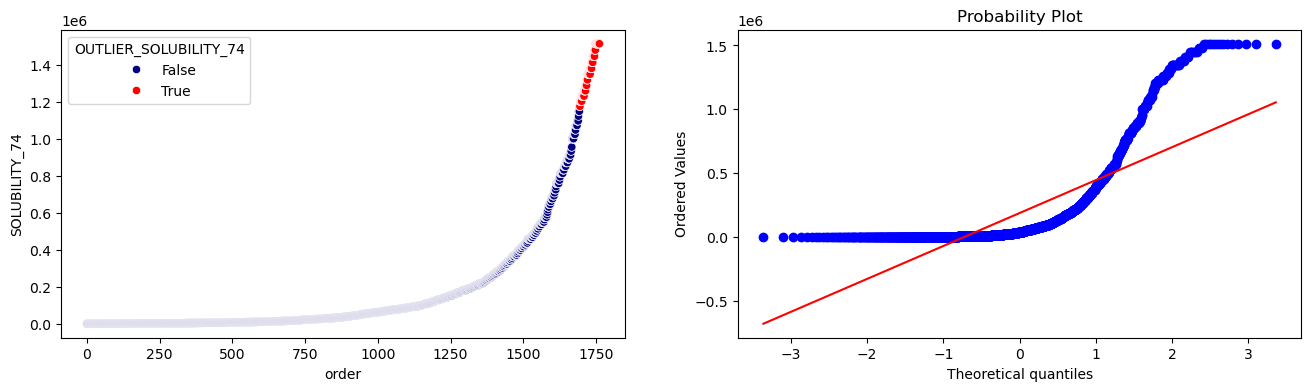

In [8]:
visualize_distribution(dataset=data_look, data_cols=data_cols);

The flagged outliers are likely false outliers as they are located on the end of the data distribution.

### Check activity shift between stereoisomers

In [9]:
data_look[[col for col in data_look.columns if "stereo_cliff" in col]].sum()

SOLUBILITY_74_stereo_cliff    64
dtype: object

64 activity shifts were detected in the dataset. Let's identify them for later removal.

In [10]:
data_look[~data_look["SOLUBILITY_74_stereo_cliff"].isna()]

,SMILES,SOLUBILITY_74,ORIGINAL_SOLUBILITY_74,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,num_undefined_stereo_center,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_SOLUBILITY_74,SOLUBILITY_74_stereo_cliff
51,C[C@H](Oc1cccc2ncnc(Nc3ccc(OCc4ccccn4)c(Cl)c3)...,4900.0,4900.0,C[C@H](Oc1cccc2ncnc(Nc3ccc(OCc4ccccn4)c(Cl)c3)...,C[C@H](Oc1cccc2ncnc(Nc3ccc(OCc4ccccn4)c(Cl)c3)...,08083a705af01f069132882dbca706d53048ade2,aa3584b29cac7ad6741817e74a3c8e4dfe5390d8,1,0,1,2,1,False,False,False,True
112,Cc1ccc(S(=O)(=O)Nc2c(C(=O)N[C@@H](C)C(C)(C)C)c...,1023300.0,1023300.0,Cc1ccc(S(=O)(=O)Nc2c(C(=O)N[C@@H](C)C(C)(C)C)c...,Cc1ccc(S(=O)(=O)Nc2c(C(=O)N[C@@H](C)C(C)(C)C)c...,102c2c38fc69c28f87472c0fc9ba79cd4a17f841,3cfbb6042a2b1f1888e8902ec41acd97affa7a27,1,0,1,2,1,False,False,False,True
138,CS(=O)(=O)c1ccc([C@@H](CC2CCCC2)C(=O)Nc2nccs2)cc1,5500.0,5500.0,CS(=O)(=O)c1ccc([C@@H](CC2CCCC2)C(=O)Nc2nccs2)cc1,CS(=O)(=O)c1ccc([C@@H](CC2CCCC2)C(=O)Nc2nccs2)cc1,15a9718a7ade35f8e4bc2679efc1f98240b42938,ac299aba84b4f9cf16ca8c53aecec1e3b5501d0e,1,0,1,2,1,False,False,False,True
182,O=C(CO)N1CCC[C@@H]1COc1cccc2ncnc(Nc3ccc(OCc4cc...,2200.0,2200.0,O=C(CO)N1CCC[C@@H]1COc1cccc2ncnc(Nc3ccc(OCc4cc...,O=C(CO)N1CCC[C@@H]1COc1cccc2ncnc(Nc3ccc(OCc4cc...,1ba1fabddf47bc004f6ebf0c1571b3f066e17bb3,e76a032b27707cdced3cd30850828f0bfc4bd74e,1,0,1,2,1,False,False,False,True
211,C[C@@H](Oc1cccc2ncnc(Nc3ccc(OCc4ccccn4)c(Cl)c3...,5600.0,5600.0,C[C@@H](Oc1cccc2ncnc(Nc3ccc(OCc4ccccn4)c(Cl)c3...,C[C@@H](Oc1cccc2ncnc(Nc3ccc(OCc4ccccn4)c(Cl)c3...,1eaab9eb8025034a560e66f3d6c229bf6c88a8f1,aa3584b29cac7ad6741817e74a3c8e4dfe5390d8,1,0,1,2,1,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656,C[C@@H](Oc1cccc2ncnc(Nc3ccc4c(cnn4Cc4nccs4)c3)...,29500.0,29500.0,C[C@@H](Oc1cccc2ncnc(Nc3ccc4c(cnn4Cc4nccs4)c3)...,C[C@@H](Oc1cccc2ncnc(Nc3ccc4c(cnn4Cc4nccs4)c3)...,f24ad345f0e5b492872163e3c479712c6c219acc,25890827507006387bbc01850ba272b8662a96b3,1,0,1,2,1,False,False,False,True
1661,C[C@@H](CN(C)C(=O)CO)Oc1cccc2ncnc(Nc3ccc(OCc4c...,8900.0,8900.0,C[C@@H](CN(C)C(=O)CO)Oc1cccc2ncnc(Nc3ccc(OCc4c...,C[C@@H](CN(C)C(=O)CO)Oc1cccc2ncnc(Nc3ccc(OCc4c...,f36425cba162b0d51b979bbe4a70f7fd55051eb8,17fc09df443a991ddbac689da7e8861c27e22fe0,1,0,1,2,1,False,False,False,True
1667,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl...,186200.0,186200.0,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl...,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl...,f47ba66990f679f442ad7073a387476a39daf904,a42f41ec4838fe42b901c794265d1113cad19f92,2,1,1,4,2,False,False,False,True
1708,CN(C(=O)Cc1ccc(-n2cnnn2)cc1)[C@@H]1CCN(Cc2ccc(...,16200.0,16200.0,CN(C(=O)Cc1ccc(-n2cnnn2)cc1)[C@@H]1CCN(Cc2ccc(...,CN(C(=O)Cc1ccc(-n2cnnn2)cc1)[C@@H]1CCN(Cc2ccc(...,fa270b725c35244b26bb9d03cefa1f7671b94c74,9e756c22485daa0e66a78b7952a349ef5c1577e3,2,0,2,4,1,False,False,False,True


### Check the molecules with undefined stereocenters

Note: feature currently not working

In [11]:
# data_look['mol'] = data_look['smiles'].apply(dm.to_mol) # Convert smiles to RDKit Mol object
# fig, _ = check_undefined_stereocenters(dataset=data_look)
# fig

In [12]:
# _[data_cols].boxplot(rot=90)

### Re-run curation, removing molecules as needed

In [13]:
### Re-run the curation steps, this time removing molecules with undefined stereoisomers and removing duplicates
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    # remove molecules that have undefined stereocenters and also show activity shift to the stereoisomers
    mask_stereo_undefined_mols=True,
    # remove all the molecule rows including the duplicates
    keep_all_rows=False,
)

print(f'size before curation: {len(data)}')
data_curated = curator_with_stereo()
print(f'size after curation: {len(data_curated)}')

size before curation: 1763


2024-04-02 13:49:18.607 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 69 outliers for data column SOLUBILITY_74 using zscore. Please revise the data and consider remove the outliers. 


size after curation: 1763


/Users/shawn.whitfield/Documents/ValenceLabs/Polaris/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True


In [14]:
# Drop molecules with stereo activity cliff
data_curated = data_curated.drop(data_curated[~data_curated["SOLUBILITY_74_stereo_cliff"].isna()].index)
data_curated

,SMILES,SOLUBILITY_74,ORIGINAL_SOLUBILITY_74,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,num_undefined_stereo_center,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_SOLUBILITY_74,SOLUBILITY_74_stereo_cliff
0,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,25700.0,25700.0,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,003579fb1182f455ecc1ab4efbc8b566f9e576a4,4f67b12a8fc665ff1b810f835f4a5f1bd2c19290,1,1,0,2,2,True,False,False,NaN
1,CC(=O)Nc1nc(-c2ccc(Br)s2)cs1,2200.0,2200.0,CC(=O)Nc1nc(-c2ccc(Br)s2)cs1,CC(=O)Nc1nc(-c2ccc(Br)s2)cs1,00657089256d9e43fbb2e3f9a464ae8f08db0a9e,28f2d6ca17fd7ab814d26cef884187a48656d1b1,0,0,0,1,1,False,True,False,NaN
2,Cc1ncc(-c2ccnc(Nc3ccc(C(=O)NC4CCN(C)CC4)cc3)n2...,871000.0,871000.0,Cc1ncc(-c2ccnc(Nc3ccc(C(=O)NC4CCN(C)CC4)cc3)n2...,Cc1ncc(-c2ccnc(Nc3ccc(C(=O)NC4CCN(C)CC4)cc3)n2...,006aa781c6428e92fe284185be78b1ef39f3fdac,65d9e835542441666fa3284964dfd86f370abe23,0,0,0,1,1,False,True,False,NaN
3,CCCCCCCCc1ccc(NC(=O)[C@H]2NCC[C@@H]2O)cc1,6900.0,6900.0,CCCCCCCCc1ccc(NC(=O)[C@H]2NCC[C@@H]2O)cc1,CCCCCCCCc1ccc(NC(=O)[C@H]2NCC[C@@H]2O)cc1,00827dce0c04b046c54f59cadd1beae5020be245,099c09c3df5c549719e3a41c54b277696835ea1f,2,0,2,4,1,False,False,False,NaN
4,COc1cc(C(=O)O)ccc1Cc1cn(C)c2ccc(NC(=O)CC3CCCC3...,186200.0,186200.0,COc1cc(C(=O)O)ccc1Cc1cn(C)c2ccc(NC(=O)CC3CCCC3...,COc1cc(C(=O)O)ccc1Cc1cn(C)c2ccc(NC(=O)CC3CCCC3...,008de8594fed2f10a725f913ab83229864fe42b9,9b8ebf30a19a5fc6d4543a29eb8371d266d7a497,0,0,0,1,1,False,True,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,COc1cc2c(Nc3cnc(NC(=O)c4ccc(F)c(Cl)c4)nc3)ncnc...,1400.0,1400.0,COc1cc2c(Nc3cnc(NC(=O)c4ccc(F)c(Cl)c4)nc3)ncnc...,COc1cc2c(Nc3cnc(NC(=O)c4ccc(F)c(Cl)c4)nc3)ncnc...,ff204dd8183b4409a7d2acf51f443cec40a2c293,3465065d5bb002382974f9146dbee883b866d568,0,0,0,1,1,False,True,False,NaN
1759,COc1ccc(C(=O)Nc2cccc(NC(=O)c3cccc(N(C)C)c3)c2)...,1400.0,1400.0,COc1ccc(C(=O)Nc2cccc(NC(=O)c3cccc(N(C)C)c3)c2)...,COc1ccc(C(=O)Nc2cccc(NC(=O)c3cccc(N(C)C)c3)c2)...,ff90ec1174d02ee2975de933c9d7cfb0ff3a4030,ace81bfd55974ca98fccb6cb7ad021509a879440,0,0,0,1,1,False,True,False,NaN
1760,CC(=O)N1CCN(CCOc2ccc(C3CCN(c4ccc5nnc(C(F)(F)F)...,5400.0,5400.0,CC(=O)N1CCN(CCOc2ccc(C3CCN(c4ccc5nnc(C(F)(F)F)...,CC(=O)N1CCN(CCOc2ccc(C3CCN(c4ccc5nnc(C(F)(F)F)...,ffb833f42c9d470a03cbea466fa2c7496f348eb4,70cf3d8997770c88ed01cc1c7b9488d78427bdee,0,0,0,1,1,False,True,False,NaN
1761,Nc1ccc(OCc2ccccc2)cc1,467700.0,467700.0,Nc1ccc(OCc2ccccc2)cc1,Nc1ccc(OCc2ccccc2)cc1,ffcbb6581f6a80c8ecf8ef96108696dcc5824839,a82a1d8b3bdd4fb5ade3d6701c6ccad9cfacb46b,0,0,0,1,1,False,True,False,NaN


In [15]:
# Additional meta-data on the column level
annotations = {
    "smiles": ColumnAnnotation(description="Molecule SMILES string", modality="molecule"),

    'SOLUBILITY_74': ColumnAnnotation(description="Solubility in pH7.4 buffer using solid starting material.",
                                      user_attributes={"PH": "7.4"}
                            ),
}

In [16]:
dataset = Dataset(
    # The table is the core data-structure required to construct a dataset
    table=data_curated,
    # Additional meta-data on the dataset level.
    name="AstraZeneca_Solubility_74",
    description="Solubility in pH7.4 buffer experiment data released by AstraZeneca",
    source="https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301364/",
    annotations=annotations,
    tags=["ADME"],
    owner=HubOwner(user_id="Shawn Whitfield", slug="swhitfield"),
    license=License(id="MIT"),
    user_attributes={"year": "2016"},
)

In [17]:
# Make a temporary directory to save the dataset
temp_dir = tempfile.TemporaryDirectory().name

save_dir = dm.fs.join(temp_dir, "dataset")

path = dataset.to_json(save_dir)

# Look at the save destination
fs = dm.fs.get_mapper(save_dir).fs
fs.ls(save_dir)

/Users/shawn.whitfield/miniconda3/envs/polaris_datasets/lib/python3.12/site-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `url` but got `str` - serialized value may not be as expected
  Expected `url` but got `str` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


['/var/folders/kq/q3sv3jmd5ys443j8rfrgmrxm0000gq/T/tmpk3qb43tp/dataset/table.parquet',
 '/var/folders/kq/q3sv3jmd5ys443j8rfrgmrxm0000gq/T/tmpk3qb43tp/dataset/dataset.json']

In [18]:
# data_curated.to_parquet(f'./data/CHEMBL3301364_curated.parquet') # Save just in case. Requires a data folder.
data_curated.to_parquet(f"gs://polaris-public/data/raw/AstraZeneca/CHEMBL3301364_curated.parquet")

In [19]:
# Load dataset through json file given
# dataset = load_dataset(path)

In [20]:
# NOTE: Commented out to not flood the DB
# with PolarisHubClient() as client:
#     client.upload_dataset(dataset=dataset)